# Esperimento guidovia - Analisi dei dati configurazione pesante pesante

Importiamo le librerie necessarie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%precision 20
np.set_printoptions(suppress=True) #sopprime la notazione scientifica

Calcoliamo l'accelerazione teorica con i dati dell'esperimento

In [2]:
m=24.3
M=309
g=9.806

acc_teorica = (m/(M+m))*g;
delta_acc = (m*g)/(M+m)**2 *0.1 + (M*g)/(M+m)**2*0.1;

print("L'accelerazione teorica in questa configurazione è %f m/s^2 con errore massimo %f m/s^2"% (acc_teorica,delta_acc))

L'accelerazione teorica in questa configurazione è 0.714929 m/s^2 con errore massimo 0.002942 m/s^2


Adesso guardiamo i dati, che apriamo direttamente da formato csv e su cui lavoreremo usando la libreria pandas. Le posizioni sono in metri e i tempi in secondi

In [3]:
df = pd.read_csv('pesantepesante.csv')
pd.set_option('display.max_columns', None)
df.head()

,Posizioni,delta,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11
0,0.6475,0.0005,0.221,0.222,0.221,0.222,0.222,0.222,0.222,0.222,0.222,0.222,0.221
1,0.6980,0.0005,0.307,0.306,0.307,0.306,0.306,0.307,0.307,0.306,0.306,0.307,0.307
2,0.7555,0.0005,0.395,0.395,0.396,0.395,0.396,0.396,0.396,0.397,0.395,0.395,0.395
3,0.8025,0.0005,0.460,0.461,0.461,0.461,0.461,0.461,0.461,0.463,0.461,0.462,0.462
4,0.8425,0.0005,0.514,0.515,0.515,0.516,0.516,0.515,0.516,0.516,0.516,0.515,0.514


Adesso ricaviamo dai dati i valori di x e y che utilizzeremo per la regressione, con i rispettivi errori sigma

In [4]:
y = df['Posizioni'].values.reshape(-1, 1) # posizioni
y_err = (df['delta'].values)/3 # errori sigma sulle posizioni

tempi=df.drop(['Posizioni','delta'], axis=1).values # tabella dei tempi da utilizzare per il calcolo delle x

x = tempi.mean(axis=1).reshape(-1, 1) #tmedio
x_err = np.array(tempi.std(axis=1,ddof = 1) + 0.001/3, dtype=np.float64) #errori sigma del tmedio

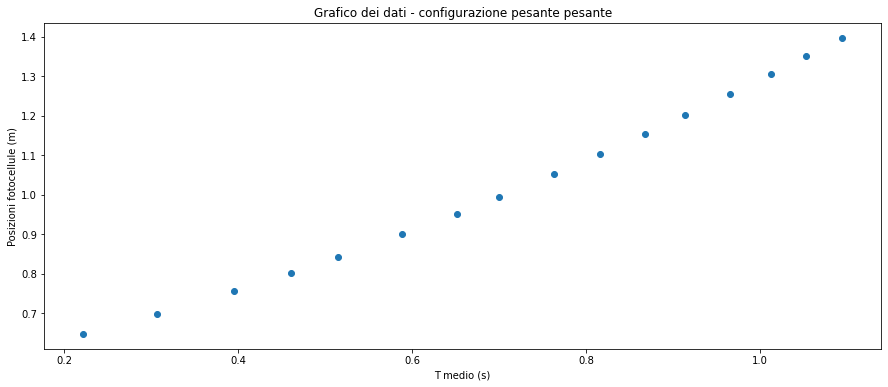

In [5]:
fig = plt.figure(figsize=(15, 6))
plt.xlabel('T medio (s)')
plt.ylabel('Posizioni fotocellule (m)')
plt.scatter(x, y)
plt.title('Grafico dei dati - configurazione pesante pesante')
plt.errorbar(x,y,xerr=x_err,yerr=y_err,linestyle="None")
plt.show() 

Plottiamo i dati con i rispettivi errori, che però non riusciamo a visualizzare perché molto piccoli

## Funzioni varie

In [6]:
#dà il minimo e la posizione di questo all'interno di un'array
def val_minimo(x):
    minimo = x[0];
    for i in range(1,len(x)):
        if x[i] < minimo:
            minimo = x[i];
            pos = i;
    return minimo, pos;

In [7]:
def find_value(x,N,pos):
    pos_1 = 0
    valore_1 = 0
    for i in range(1,len(x)):
        if (x[i] - (N+1))**2 <0.0000015:
            valore_1 = x[i]
            pos_1 = i;
            break;
    
    pos_2 = 2*(pos - pos_1) + pos_1;
    valore_2 = x[pos_2]
    return pos_1,pos_2;

In [8]:
def regressione(x,y, weights = np.ones(len(x)), grafico = True,C = None):
    
    sumx1 = sumy1 = sumxy = sumx2 = sumx3 = sumx4 = sumx2y = delta = delta1 = delta2 = delta3 = delta4 = 0;
    M = 0;
    
    for i in range(len(x)):
        M += weights[i];
        sumx1 += weights[i]*x[i];
        sumy1 += weights[i]*y[i];
        sumxy += weights[i]*x[i]*y[i];
        sumx2 += weights[i]*x[i]**2;
        sumx3 += weights[i]*x[i]**3;
        sumx4 += weights[i]*x[i]**4;
        sumx2y += weights[i]*x[i]**2*y[i];
    if (C == None):
        delta = M* sumx2* sumx4 + sumx1* sumx3 *sumx2 + sumx2* sumx1*sumx3 - (sumx2**3) - M*sumx3**2 -  sumx4*(sumx1**2);
        delta1 = sumy1* sumx2* sumx4 + sumx1* sumx3 *sumx2y + sumx2* sumxy*sumx3 - sumx2y*(sumx2**2) - (sumx3**2)*sumy1 - sumx4*sumx1*sumxy;
        delta2 = M* sumxy* sumx4 + sumy1* sumx3 *sumx2 + sumx2* sumx1*sumx2y - (sumx2**2)*sumxy - sumx2y*sumx3*M -  sumx4*sumy1*sumx1;
        delta3 = M* sumx2* sumx2y + sumx1* sumxy *sumx2 + sumy1* sumx1*sumx3 - (sumx2**2)*sumy1 - sumx3*sumxy*M -  sumx2y*(sumx1**2);
    
        A = delta1/delta;
        B = delta2/delta;
        C = delta3/delta;

        #print(delta, delta1,delta2,delta3)
    
    else:
        delta=(M*sumx2)-(sumx1*sumx1)
        A = (sumx2*(sumy1-C*sumx2)-(sumxy-C*sumx3)*sumx1)/delta;
        B = (M*(sumxy-C*sumx3)-(sumx1*(sumy1-C*sumx2)))/delta;

        
    sigma_A = np.sqrt(((sumx2*sumx4) - (sumx3)**2)/(M* sumx2* sumx4 + sumx1* sumx3 *sumx2 + sumx2* sumx1*sumx3 - (sumx2**3) - M*sumx3**2 -  sumx4*(sumx1**2)));
    sigma_B = np.sqrt(((M*sumx4) - (sumx2)**2)/(M* sumx2* sumx4 + sumx1* sumx3 *sumx2 + sumx2* sumx1*sumx3 - (sumx2**3) - M*sumx3**2 -  sumx4*(sumx1**2)));
    sigma_C = np.sqrt(((M*sumx2) - (sumx1)**2)/(M* sumx2* sumx4 + sumx1* sumx3 *sumx2 + sumx2* sumx1*sumx3 - (sumx2**3) - M*sumx3**2 -  sumx4*(sumx1**2)));
    
    
    #grafico della regressione
    
    if grafico == True:
        
        X_fit = np.arange(0,1.7,0.001).reshape(-1, 1)
        Y_fit = np.zeros(len(X_fit))
        for i in range(len(X_fit)):
            Y_fit[i] = A + B*X_fit[i] + C*X_fit[i]**2
    
        fig = plt.figure(figsize=(15, 6))
        plt.scatter(x, y)
        plt.plot(X_fit, Y_fit)
        plt.xlabel('T medio (s)')
        plt.ylabel('Posizioni fotocellule (m)')
        plt.title('Regressione')
        plt.show()
        
    
    return A,B, C,sigma_A, sigma_B, sigma_C;

In [9]:
def chiquadro(x,y, y_err,A,B,C):
    
    chisquare = 0;
    for i in range(16):
        chisquare +=  (y[i]-A -B*x[i]-C*x[i]**2)**2/y_err[i]**2

    return chisquare;

In [10]:
def residui(x,y, y_err,A,B,C,grafico = True):  
    
    residui_tot = np.zeros(16, dtype = np.float64);
    for i in range(16):
        residui_tot[i] = y[i] - (A + B*x[i]+C*x[i]**2)
        
    if grafico == True:
        fig = plt.figure(figsize = (15, 6))

        plt.scatter(x,residui_tot)
        plt.errorbar(x,residui_tot,y_err, linestyle = "None")

        plt.xlabel('T medio (s)')
        plt.ylabel('Residui')
        plt.title('Grafico dei residui')
        plt.show()
    
    
    return residui_tot;

In [11]:
def errori(B,C,x_err,y_err):
    pesi = np.zeros(16, dtype = np.float64)
    y_err_tot = np.zeros(16, dtype = np.float64)
    for i in range(16):
        y_err_tot[i] = np.sqrt(y_err[i]**2+((B+2*C*x[i])**2)*x_err[i]**2);
        pesi[i] = 1/(y_err_tot[i]**2)
    return y_err_tot, pesi;

In [12]:
def regressione_iterativa_c(N,x,y,B,C_min, C_max,y_finali,passo, y_err,x_err):

    chi_quadrato_opt = np.zeros(N, dtype = np.float64);
    C_passi = np.arange(C_min,C_max,passo, dtype = np.float64)
    lista_A = np.zeros(N, dtype = np.float64)
    lista_B = np.zeros(N, dtype = np.float64)
    lista_sigma_A = np.zeros(N, dtype = np.float64)
    lista_sigma_B = np.zeros(N, dtype = np.float64)
    lista_sigma_C = np.zeros(N, dtype = np.float64) 
    B_old = B;
    for count in range(N):
        y_err_tot, pesi = errori(B_old,C_passi[count],x_err,y_err)
        A_new,B_new,C,sigma_A, sigma_B, sigma_C = regressione(x,y,pesi,grafico = False,C = C_passi[count]);
        residui_new = residui(x,y, y_err_tot,A_new,B_new,C_passi[count],grafico = False);
        
        chisquare_new = chiquadro(x,y,y_err_tot, A_new,B_new,C_passi[count]);
        chi_quadrato_opt[count] = chisquare_new;
        lista_A[count] = A_new;
        lista_B[count] = B_new;
        
        lista_sigma_A[count] = sigma_A;
        lista_sigma_B[count] = sigma_B;
        lista_sigma_C[count] = sigma_C;
        #print('I coefficienti della %d iterazione sono, A: %.10f, B: %.10f C: %.10f, con chi quadro %.10f e chi quadro ridotto %.10f' %(count, lista_A[count],lista_B[count],C_passi[count], chisquare_new, chisquare_new/13));
        #print(residui_new)
        B_old = B_new;
    
    minimo,pos = val_minimo(chi_quadrato_opt);
    
    
    #Grafico del chiquadro
    fig = plt.figure(figsize = (15, 6))
    x_retta = (C_min,C_max)
    y_retta = (minimo + 1,minimo + 1)
    plt.plot(C_passi,chi_quadrato_opt)
    plt.plot(x_retta, y_retta)

    plt.xlabel('C passi')
    plt.ylabel('Chi quadro')
    plt.title('Grafico dei chi quadro')
    
    plt.xticks(np.arange(C_min, C_max,step = passo*1000))
    plt.yticks(np.arange(int(chi_quadrato_opt.min()), int(chi_quadrato_opt.max()), step = 0.1))
    plt.show()

    
    
    pos_1,pos_2 = find_value(chi_quadrato_opt, minimo,pos)
    sigma_v3=(C_passi[pos_2]- C_passi[pos_1])/2
    
    A_new,B_new,C,sigma_A, sigma_B, sigma_C = regressione(x,y,pesi,grafico = True,C = C_passi[pos]);
    print("il valore minimo del chi quadrato si trova all'iter. %d ed è %.10f a cui corrisponde un C best %.10f, sigma C (calcolato) %.10f e corrispondenti A %.10f con sigma A %.10f e B %.10f con sigma B %.10f"% (pos,minimo,C_passi[pos], sigma_C,lista_A[pos],lista_sigma_A[pos],  lista_B[pos],lista_sigma_B[pos] ))

    print("il valore minimo di C sarà %.10f %.10f, il sigma C (heuristic) invece %.10f" % (C_passi[pos_1], C_passi[pos_2], sigma_v3))
        
    y_err_tot, pesi = errori(lista_B[pos],C_passi[pos],x_err,y_err)
    residui_new = residui(x,y, y_err_tot,lista_A[pos],lista_B[pos],C_passi[pos],grafico = True)
    
    return lista_A[pos], lista_B[pos],C_passi[pos], lista_sigma_A[pos], lista_sigma_B[pos], sigma_C,y_finali,chi_quadrato_opt[pos],sigma_v3;

## Regressioni

### 1 regressione, ci serve per calcolare valori iniziali A B e C


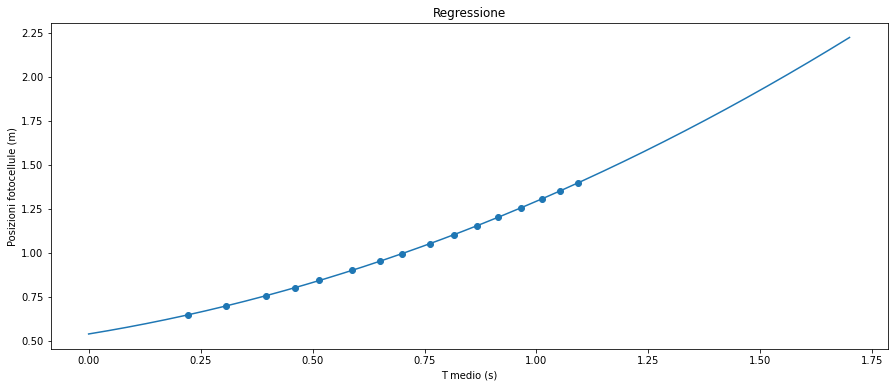

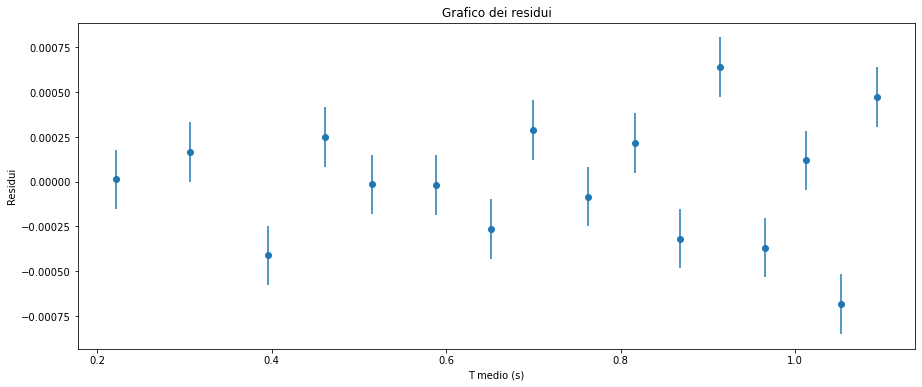

I primi coefficienti sono, A: 0.5389255573, B: 0.4144118991 C: 0.3391816438, con chi quadro 65.3644424245 e chi quadro ridotto 5.0280340327


In [13]:
A,B,C, sigma_A, sigma_B, sigma_C = regressione(x,y)

chisquare = chiquadro(x,y, y_err,A,B,C)
residui_tot = residui(x,y, y_err,A,B,C)
y_err_tot, pesi = errori(B,C,x_err,y_err)
print('I primi coefficienti sono, A: %.10f, B: %.10f C: %.10f, con chi quadro %.10f e chi quadro ridotto %.10f' %(A,B,C, chisquare, chisquare/13))

### 2 regressione, ci serve per calcolare C_min e C_max

In [14]:
A,B,C, sigma_A, sigma_B, sigma_C = regressione(x,y,weights = pesi,grafico = False)
y_err_tot, pesi = errori(B,C,x_err,y_err)

In [15]:
N = 10000
C_min = C - 1.5*sigma_C; #valore di C_min trovato precedentemente
passo = (3*sigma_C)/N
C_max = C + 1.5*sigma_C-0.0000001;
C_max

array([0.3444517632520569])

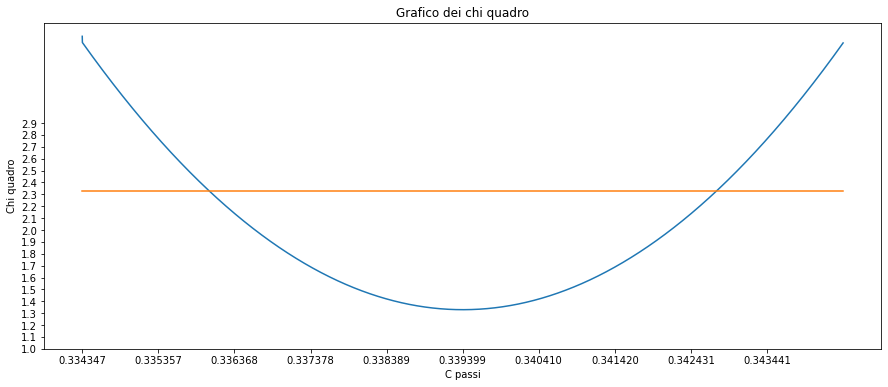

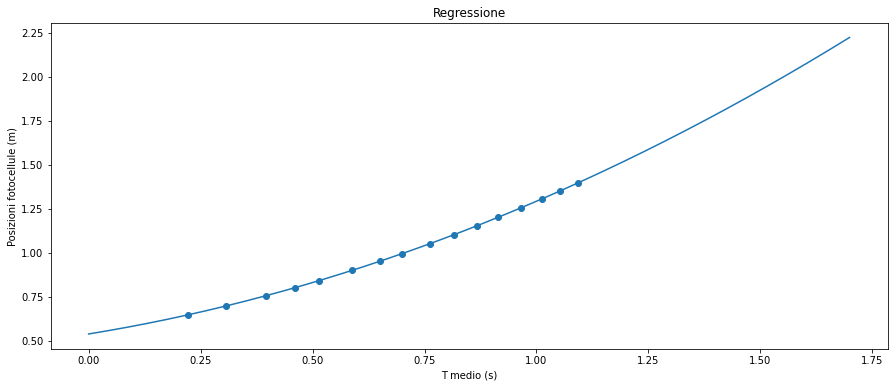

il valore minimo del chi quadrato si trova all'iter. 5002 ed è 1.3292038815 a cui corrisponde un C best 0.3394013004, sigma C (calcolato) 0.0033683703 e corrispondenti A 0.5389996774 con sigma A 0.0010711016 e B 0.4141446105 con sigma B 0.0040931923
il valore minimo di C sarà 0.3360302165 0.3427723844, il sigma C (heuristic) invece 0.0033710840


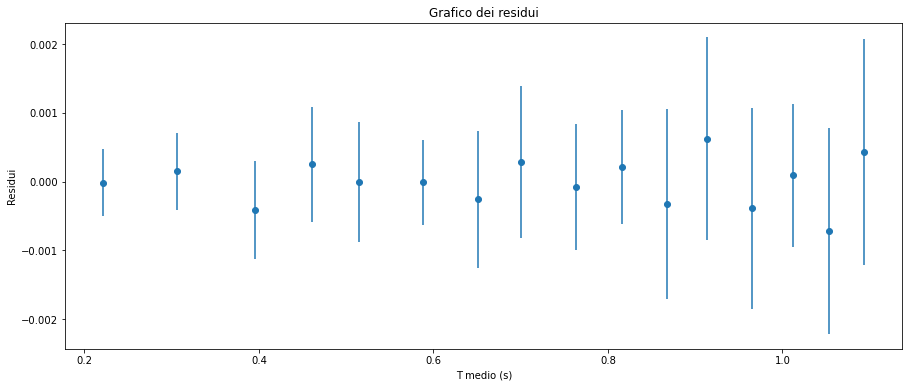

In [16]:
A,B,C_best, sigma_A,sigma_B, sigma_C_best, y_finali,chiq, sigma_v3 = regressione_iterativa_c(N,x,y,B,C_min,C_max,y_err_tot, passo,y_err,x_err);

Il sigma calcolato ci dà comunque il sigma C minore, quindi terremo quello

In [17]:
print("chiquadrato ridotto:", chiq/13)
(1.3292073450-2.3290361978+1)**2

chiquadrato ridotto: 0.10224645242105002


0.00000002929136406788

In pratica noi ipotizziamo che i nostri dati sono descritti correttamente dalla funzione $A+Bx+Cx^2$, e con il chi quadro testiamo quanto probabile è questa nostra ipotesi. Un valore di $\tilde{\chi}^2 \approx 1$ (cioè il valore atteso della distribuzione $\tilde{\chi}^2$) sarebbe ideale. 

La probabiità di ottenere un valore di chi quadro ridotto maggiore o uguale a 0.18 in un esperimento con 13 gradi di libertà, cioè la $P_{dof}(\tilde{\chi}^2 \geq 0.18) \approx 99\%$, con l'ipotesi nulla che l'adattamento funzionale è corretto (cioè che i coefficienti spiegano con buona aprossimazione i dati), che è abbastanza grande da poter pensare che l'ipotesi sia corretta.

In effetti osserviamo che i residui sono molto molto piccoli rispetto all'errore totale su y, questo ci fa pensare che sia naturale che il chi-quadro venga più piccolo di uno, e che non potrebbe non essere solo un problema di sovrastima degli errori, che sono comunque dello stesso ordine di grandezza della configurazione leggera, ma piuttosto che i dati spiegano perfettamente il modello. Dato che non abbiamo raccolto noi i dati, non possiamo sapere nulla del procedimento di misurazione con qui sono stati presi, ma abbiamo forti sospetti che i dati siano stati "corretti".

## Errori con la radice quadrata del chi quadro ridotto

Per ottenere stime migliori dei coefficienti A, B e C possiamo moltiplicare gli errori per una quantità uguale a $\sqrt{\tilde{\chi_{0}}^2}$ così da ridurli. Otterremo così un $\tilde{\chi}_{0}^2 \approx 1$

In [18]:
y_err_fin = np.zeros(16);
pesi_fin = np.zeros(16);
for i in range(16):
    y_err_fin[i] = y_err_tot[i]*np.sqrt(chiq/13)
    pesi_fin[i] = 1/y_err_fin[i]**2

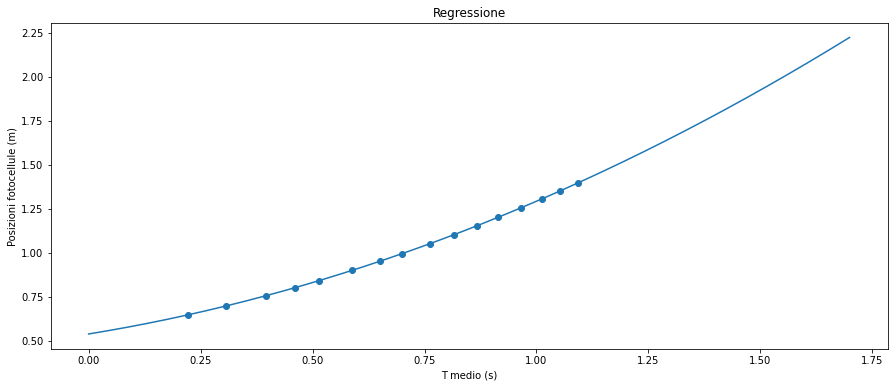

In [19]:
A_rid,B_rid,C_rid, sigma_A_rid, sigma_B_rid, sigma_C_rid= regressione(x,y,pesi_fin);

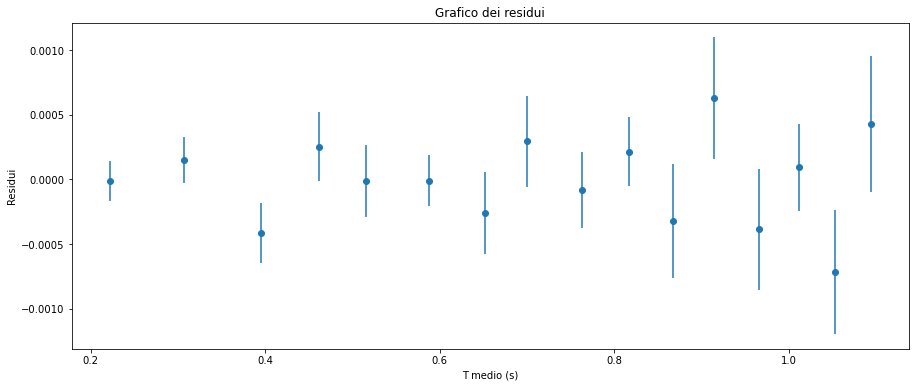

In [20]:
residui_fin=residui(x,y, y_err_fin,A,B,C)
#print("residui:", residui_fin)
#print("errore totale su y:", y_err_fin)

In [21]:
chisquare_fin=chiquadro(x,y, y_err_fin,A,B,C)
print('I coefficienti della iterazione sono, A: %f, B: %f C: %f, con errori sigma A: %f sigma B %f sigma C %f e chi quadro %f e chi quadro ridotto %f' %(A_rid,B_rid,C_rid,sigma_A_rid, sigma_B_rid, sigma_C_rid, chisquare_fin, chisquare_fin/13))

I coefficienti della iterazione sono, A: 0.538999, B: 0.414147 C: 0.339399, con errori sigma A: 0.000342 sigma B 0.001309 sigma C 0.001077 e chi quadro 13.000239 e chi quadro ridotto 1.000018


Come possiamo vedere il chiquadro ridotto è migliorato. Infatto adesso, la probabiità di ottenere un valore di chi quadro ridotto maggiore o uguale a \approx 1 in un esperimento con 13 gradi di libertà, è $P_{dof}(\tilde{\chi}^2 \geq 1) \approx 45\%$.

Ciò però è causato dal fatto che abbiamo reso più piccolo l'errore totale su y, e otteniamo un chi quadro perfetto ma ha senso farlo visto che ora le barre d'errore non passano nemmeno per lo zero?

## Conclusioni

Confrontiamo i due risultati (sperimentale e teorico), riportando tutti gli errori a un livello di confidenza del 100\%

In [22]:
sigma_C_prop = 2*sigma_C*3 #regressione pesata
sigma_C_prop_2 = 2*sigma_C_rid*3 #regressione con errori totali finali pesati per radice quadrato di chi ridotto
sigma_C_prop_3 = 2*sigma_v3*3 #sigma c ottenuto con metodo minimizzazione chiquadro

In [23]:
print('accelerazione sperimentale, calcolata col 1 metodo: %f +- %f' %(2*C,sigma_C_prop)) 
print('accelerazione sperimentale, calcolata col 2 metodo: %f +- %f  errore relativo: %f' %(2*C_rid,sigma_C_prop_2, sigma_C_prop_2/(2*C_rid))) 
print('accelerazione sperimentale, calcolata col 3 metodo: %f +- %f' %(2*C,sigma_C_prop_3)) 

accelerazione sperimentale, calcolata col 1 metodo: 0.678799 +- 0.020210
accelerazione sperimentale, calcolata col 2 metodo: 0.678799 +- 0.006462  errore relativo: 0.009520
accelerazione sperimentale, calcolata col 3 metodo: 0.678799 +- 0.020227


In [24]:
print('accelerazione teorica: %f +- %f m/s^2'% (acc_teorica, delta_acc));

accelerazione teorica: 0.714929 +- 0.002942 m/s^2


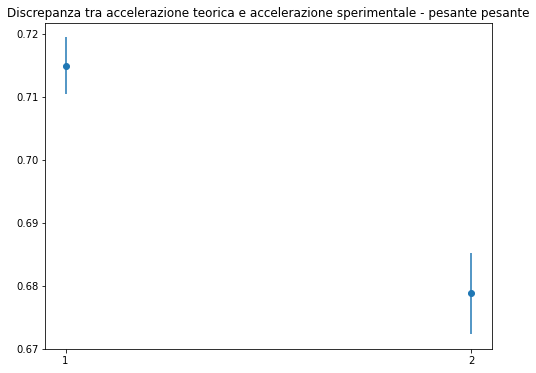

[0.036130143271016935] [0.007845024908034338]


In [34]:
x = np.array([1,2], dtype=int)
y = np.array([acc_teorica,2*C_rid], dtype = float)
fig = plt.figure(figsize=(8, 6))
plt.scatter(x,y)
plt.xticks([1,2])

erorr= np.array([float(delta_acc),float(sigma_C_prop_2)], dtype = float)
plt.title('Discrepanza tra accelerazione teorica e accelerazione sperimentale - pesante pesante')
plt.errorbar(x,y,yerr=erorr,linestyle="None")

plt.show() 

discrepanza = abs(acc_teorica -2*C_rid)
discr_err = np.sqrt((delta_acc)**2 + (sigma_C_prop_2)**2)
print(discrepanza, discr_err)
#discr_err vale 3 sigma perché errore massimo, quindi l'intervallo 

Calcoliamo il coefficiente di attrito

In [30]:
#1
coeff_attrito= (-(2*C)*(M+m) +m*g)/(M*g)

#errore al 100% di confidenza
eps_tot = abs(((g-2*C)/(M)*g)*0.1)+abs((((2*C-g)*(m))/(M)**2*g)*0.1)+abs((-((M+m))/(M)*g)*sigma_C_prop) #propagazione

delta_att= abs(eps_tot*coeff_attrito)
print('coefficiente di attrito: %f +- %f m/s^2'% (coeff_attrito,delta_att))


coefficiente di attrito: 0.003974 +- 0.000974 m/s^2


In [35]:
#2
coeff_attrito= (-(2*C)*(M+m) +m*g)/(M*g)

#errore al 100% di confidenza
eps_tot = abs(((g-2*C)/(M)*g)*0.1)+abs((((2*C-g)*(m))/(M)**2*g)*0.1)+abs((-((M+m))/(M)*g)*sigma_C_prop_2) #propagazione

delta_att= abs(eps_tot*coeff_attrito)
print('coefficiente di attrito: %f +- %f m/s^2'% (coeff_attrito,delta_att))
delta_att/coeff_attrito

coefficiente di attrito: 0.003974 +- 0.000396 m/s^2


array([0.09959657776773653])

In [32]:
a_finale_teorica = ((m - M*coeff_attrito)/(M+m))*g;

#errore al 100% di confidenza
eps_tot_a_teorica = abs(((M*g*(1+coeff_attrito))/((M+m)**2))*0.1)+abs((((m*g*(1+coeff_attrito))/((M+m)**2))*0.1)+abs(-(M*g)/(M+m))*delta_att) #propagazione

delta_acc = abs(eps_tot_a_teorica*a_finale_teorica)
a_finale_teorica

print('accelerazione teorica finale: %f +- %f m/s^2'% (a_finale_teorica,delta_acc))


accelerazione teorica finale: 0.678799 +- 0.004448 m/s^2


In [29]:
errore_relativo_att= delta_att/coeff_attrito;
errore_relativo_att

array([0.09959657776773653])